In [2]:
! pip install git+https://github.com/openai/CLIP.git

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import os
import numpy as np
import clip as openai_clip
import torch
import torchvision
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image

# !nvidia-smi

  Cloning https://github.com/openai/CLIP.git to /private/var/folders/ss/lq5kn2n913gdx9zsvl2yk9500000gn/T/pip-req-build-rin57jgk
  Running command git clone -q https://github.com/openai/CLIP.git /private/var/folders/ss/lq5kn2n913gdx9zsvl2yk9500000gn/T/pip-req-build-rin57jgk
  Resolved https://github.com/openai/CLIP.git to commit 04f4dc2ca1ed0acc9893bd1a3b526a7e02c4bb10


# Load Models

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
vgg16 = models.vgg16(pretrained=True)
resnet18 = models.resnet18(pretrained=True)
clip, preprocess = openai_clip.load("ViT-B/32", device=device, jit=False)

# Encode Images

torch.Size([4096])
torch.Size([512])
torch.Size([1, 512])
torch.Size([4096])
torch.Size([512])
torch.Size([1, 512])
torch.Size([4096])
torch.Size([512])
torch.Size([1, 512])
torch.Size([4096])
torch.Size([512])
torch.Size([1, 512])
torch.Size([4096])
torch.Size([512])
torch.Size([1, 512])
torch.Size([4096])
torch.Size([512])
torch.Size([1, 512])
torch.Size([4096])
torch.Size([512])
torch.Size([1, 512])
torch.Size([4096])
torch.Size([512])
torch.Size([1, 512])


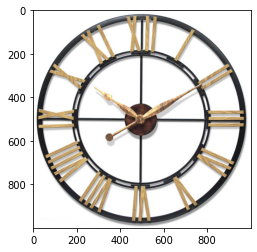

In [4]:
def get_vgg_features(img):
  layer = vgg16._modules.get("avgpool")
  resnet18.eval()
  t_img = transforms(img)
  img_features = torch.zeros(4096)
  def copy_data(m, i, o):
    img_features.copy_(o.flatten())
  h = layer.register_forward_hook(copy_data)
  with torch.no_grad():
    resnet18(t_img.unsqueeze(0))  
  h.remove()
  print(img_features.shape)
  return img_features

def get_resnet_features(img):
  layer = resnet18._modules.get("avgpool")
  resnet18.eval()
  t_img = transforms(img)
  img_features = torch.zeros(512)
  def copy_data(m, i, o):
    img_features.copy_(o.flatten())
  h = layer.register_forward_hook(copy_data)
  with torch.no_grad():
    resnet18(t_img.unsqueeze(0))  
  h.remove()
  print(img_features.shape)
  return img_features

def get_clip_features(img):
  img_features = clip.encode_image(preprocess(img).unsqueeze(0).to(device))
  img_features /= img_features.norm(dim=-1, keepdim=True)
  print(img_features.shape)
  return img_features

root = "ikea/images/"

transforms = torchvision.transforms.Compose([
  torchvision.transforms.Resize(256),
  torchvision.transforms.CenterCrop(224),
  torchvision.transforms.ToTensor(),
  torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# the dataset has images in subfolders by category
for subdir, dirs, files in os.walk(root):
  for file in files:
    if not file.startswith('.'):
      with torch.no_grad():
        # img_path = os.path.join(root, subdir, file)
        img_path = os.path.join(subdir, file)
        img = Image.open(img_path).convert("RGB") 
        vgg_features = get_vgg_features(img)
        resnet_features = get_resnet_features(img)
        clip_features = get_clip_features(img)
        plt.imshow(np.asarray(img)) # display image
        # break